In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
%matplotlib widget

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import time
import xarray as xr
from scipy.stats import zscore

In [4]:
from neurodsp.plts.time_series import plot_time_series, plot_bursts
from ripple_detection.core import gaussian_smooth

In [49]:
from ecephys.data import paths
from ecephys.utils import load_df_h5, add_attrs, replace_outliers
from ecephys.scoring import load_visbrain_hypnogram, make_empty_hypnogram
from ecephys.signal.sharp_wave_ripples import get_epoched_event_density
import ecephys.plot as eplt

In [8]:
SUBJECT = "Doppio"
CONDITION = "REC-2-0"
RECORDING_LENGTH = 7200

In [9]:
lfp_bandpower = xr.open_dataset(paths.get_datapath(subject=SUBJECT, condition=CONDITION, data="lfp_bandpower.nc"))
emg = xr.open_dataset(paths.get_datapath(subject=SUBJECT, condition=CONDITION, data="emg.nc")).emg
with pd.HDFStore(paths.get_datapath(subject=SUBJECT, condition=CONDITION, data="sharp_waves.h5")) as store:
    spws, spw_metadata = load_df_h5(store)
    spws = add_attrs(spws, **spw_metadata)
    
try:
    hypnogram_path = paths.get_datapath(subject=SUBJECT, condition=CONDITION, data="hypnogram.txt")
except IndexError:
    hypnogram = make_empty_hypnogram(RECORDING_LENGTH)
else:
    hypnogram = load_visbrain_hypnogram(hypnogram_path)

In [10]:
def my_gaussian_smooth(da, smoothing_sigma=10):
    estimated_fs = 1 / np.diff(da.time.values).mean()
    return gaussian_smooth(da, smoothing_sigma, estimated_fs)

In [11]:
epochs = get_epoched_event_density(spws, np.min(hypnogram.start_time), np.max(hypnogram.end_time), epoch_length=10)
td = (lfp_bandpower.sr_theta / lfp_bandpower.sr_delta).values
td_smooth = my_gaussian_smooth(lfp_bandpower.sr_theta / lfp_bandpower.sr_delta, smoothing_sigma=4)
density = gaussian_smooth(epochs.event_density.to_numpy(), 10, 0.1)

In [12]:
fig, axes = plt.subplots(6, 1, figsize=(20, 10))
plot_time_series(lfp_bandpower.time.values, lfp_bandpower.sr_delta.values, ax=axes[0], title="Stratum radiatum delta (0.5 - 4 Hz)", ylabel="PSD (uV$^2$/Hz)")
plot_time_series(lfp_bandpower.time.values, lfp_bandpower.sr_theta.values, ax=axes[1], title="Stratum radiatum theta (5 - 10 Hz)", ylabel="PSD (uV$^2$/Hz)")
plot_time_series(lfp_bandpower.time.values, td, ax=axes[2], title="Theta / Delta ratio", ylabel="Ratio")
plot_time_series(lfp_bandpower.time.values, td_smooth, ax=axes[3], title="Theta / Delta ratio, smoothed w/ 4-second gaussian", ylabel="Ratio")
plot_time_series(emg.time.values, emg.values, ax=axes[4], title="Buzsaki-style EMG", ylabel="Corr")
plot_time_series(epochs.midpoint.to_numpy(), epochs.event_density.to_numpy(), ax=axes[5], title="SPW density (10s epochs)", ylabel="Hz")
for i in range(1, len(axes)):
    axes[i].set_xlim(axes[0].get_xlim())

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

In [13]:
fig, ax1 = plt.subplots(figsize=(22, 3))
plot_time_series(lfp_bandpower.time.values, td_smooth, ax=ax1, title = "Theta/delta ratio (red) vs. SR sink density (black)", ylabel="Ratio", colors='red')
ax2 = ax1.twinx()
plot_time_series(epochs.midpoint.to_numpy(), density, ax=ax2, ylabel="Hz")

#ax1.axhline(threshold)

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

### Can the distribution of smoothed theta/delta ratios be separated? Maybe using KDE or GMM

In [14]:
from ripple_detection.core import segment_boolean_series

def below_threshold_intervals(sig, threshold, time):
    _is_below_threshold = pd.Series(sig < threshold, index=time)
    return segment_boolean_series(_is_below_threshold, minimum_duration=0)

def above_threshold_intervals(sig, threshold, time):
    _is_below_threshold = pd.Series(sig > threshold, index=time)
    return segment_boolean_series(_is_below_threshold, minimum_duration=0)

In [15]:
fig, ax1 = plt.subplots()
plt.hist(td_smooth, bins=100)
#ax1.axvline(np.quantile(td_smooth, 0.25), color='r')
#ax1.axvline(np.quantile(td_smooth, 0.50), color='g')
plt.show()

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

In [16]:
fig, ax1 = plt.subplots()
plt.hist(np.log(td_smooth), bins=100)
plt.show()

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

In [17]:
fig, ax1 = plt.subplots()
plt.hist(zscore(np.log(td_smooth)), bins=100)
plt.show()

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

In [18]:
tds_threshold = td_smooth[zscore(np.log(td_smooth)) < 1].max()
print(tds_threshold)
tds_below_threshold_intervals = below_threshold_intervals(td_smooth, tds_threshold, lfp_bandpower.time.values)

5.43151315557674


In [19]:
fig, ax1 = plt.subplots(figsize=(22, 3))
plot_time_series(lfp_bandpower.time.values, td_smooth, ax=ax1, ylabel="Ratio", colors='red')
ax2 = ax1.twinx()
plot_time_series(epochs.midpoint.to_numpy(), density, ax=ax2, ylabel="Hz")

ax1.axhline(tds_threshold)

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

#### If bimodal

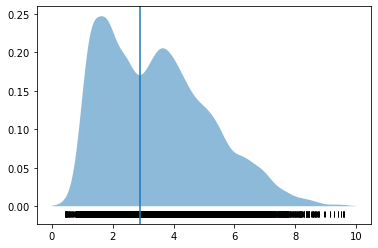

In [180]:
from sklearn.neighbors import KernelDensity

x = td_ratio
x_d = np.linspace(0, 10, 1000)

# instantiate and fit the KDE model
kde = KernelDensity(bandwidth=0.25, kernel='gaussian')
kde.fit(x[:, None])

# score_samples returns the log of the probability density
logprob = kde.score_samples(x_d[:, None])

plt.fill_between(x_d, np.exp(logprob), alpha=0.5)
plt.plot(x, np.full_like(x, -0.01), '|k', markeredgewidth=1)
plt.axvline(threshold)

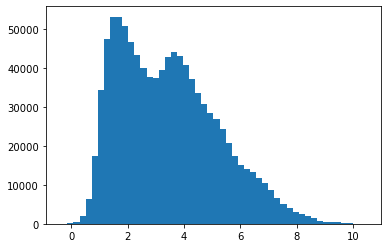

In [125]:
fig, ax1 = plt.subplots()
plt.hist(kde.sample(int(1e6)), bins=50)
plt.show()

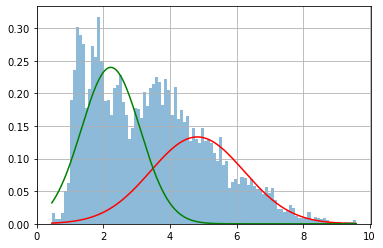

In [167]:
from matplotlib import rc
from sklearn import mixture
import matplotlib.pyplot as plt
import numpy as np
import matplotlib
import matplotlib.ticker as tkr
import scipy.stats as stats

# x = open("prueba.dat").read().splitlines()

# create the data
x = td_ratio

f = np.ravel(x).astype(np.float)
f=f.reshape(-1,1)
g = mixture.GaussianMixture(n_components=2,covariance_type='full')
g.fit(f)
weights = g.weights_
means = g.means_
covars = g.covariances_

plt.hist(f, bins=100, histtype='bar', density=True, alpha=0.5)

f_axis = f.copy().ravel()
f_axis.sort()
plt.plot(f_axis,weights[0]*stats.norm.pdf(f_axis,means[0],np.sqrt(covars[0])).ravel(), c='red')
plt.plot(f_axis,weights[1]*stats.norm.pdf(f_axis,means[1],np.sqrt(covars[1])).ravel(), c='green')


plt.grid()
plt.show()

In [585]:
from matplotlib import rc
from sklearn import mixture
import matplotlib.pyplot as plt
import matplotlib.ticker as tkr
import scipy.stats as stats

# x = open("prueba.dat").read().splitlines()

# create the data
x = td_ratio

f = np.ravel(x).astype(np.float)
f=f.reshape(-1,1)
g = mixture.GaussianMixture(n_components=3,covariance_type='full')
g.fit(f)
weights = g.weights_
means = g.means_
covars = g.covariances_

plt.hist(f, bins=100, histtype='bar', density=True, alpha=0.5)

f_axis = f.copy().ravel()
f_axis.sort()
plt.plot(f_axis,weights[0]*stats.norm.pdf(f_axis,means[0],np.sqrt(covars[0])).ravel(), c='red')
plt.plot(f_axis,weights[1]*stats.norm.pdf(f_axis,means[1],np.sqrt(covars[1])).ravel(), c='green')
plt.plot(f_axis,weights[2]*stats.norm.pdf(f_axis,means[2],np.sqrt(covars[2])).ravel(), c='yellow')


plt.grid()
plt.show()

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

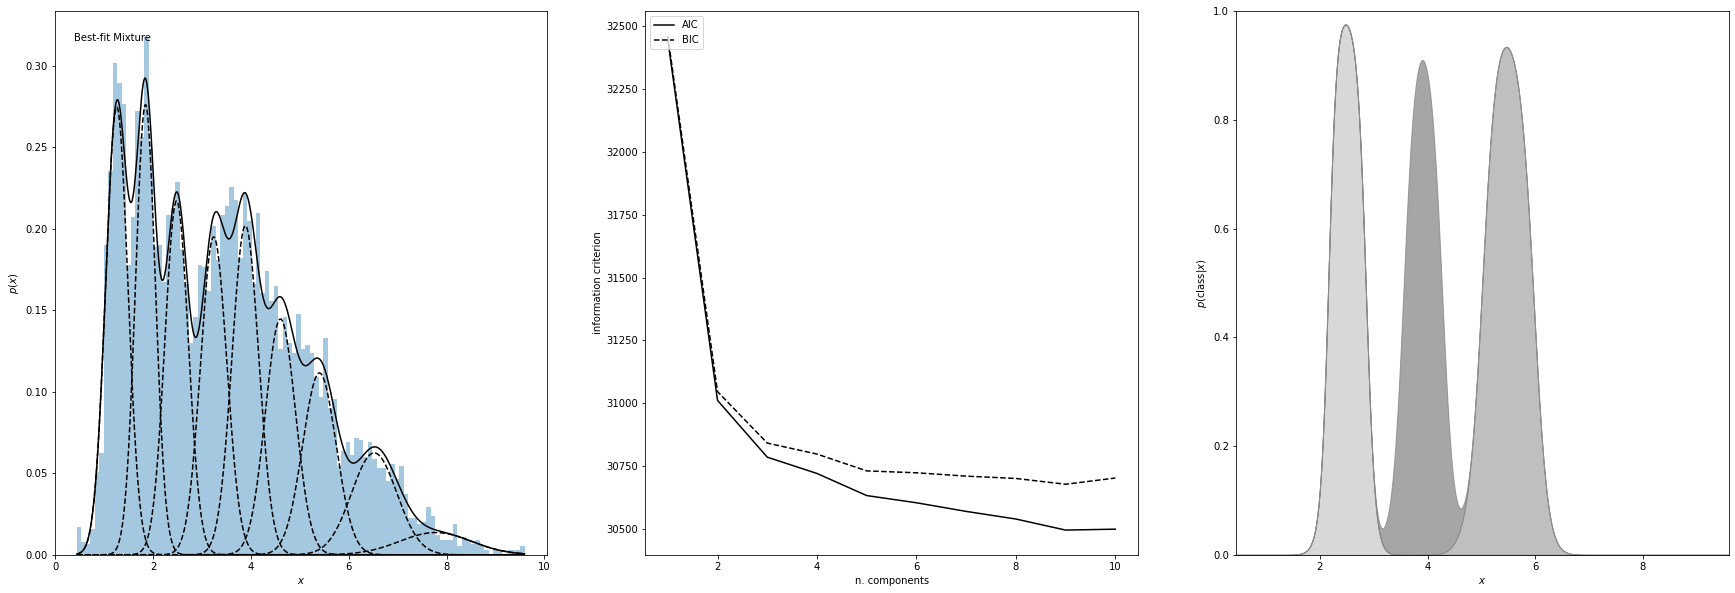

In [162]:
# Author: Jake VanderPlas
# License: BSD
#   The figure produced by this code is published in the textbook
#   "Statistics, Data Mining, and Machine Learning in Astronomy" (2013)
#   For more information, see http://astroML.github.com
#   To report a bug or issue, use the following forum:
#    https://groups.google.com/forum/#!forum/astroml-general
from matplotlib import pyplot as plt
import numpy as np
from sklearn.mixture import GaussianMixture

#----------------------------------------------------------------------
x = td_ratio
f = np.ravel(x).astype(np.float)
f=f.reshape(-1,1)
X = f

#------------------------------------------------------------
# Learn the best-fit GaussianMixture models
#  Here we'll use scikit-learn's GaussianMixture model. The fit() method
#  uses an Expectation-Maximization approach to find the best
#  mixture of Gaussians for the data

# fit models with 1-10 components
N = np.arange(1, 11)
models = [None for i in range(len(N))]

for i in range(len(N)):
    models[i] = GaussianMixture(N[i]).fit(X)

# compute the AIC and the BIC
AIC = [m.aic(X) for m in models]
BIC = [m.bic(X) for m in models]

#------------------------------------------------------------
# Plot the results
#  We'll use three panels:
#   1) data + best-fit mixture
#   2) AIC and BIC vs number of components
#   3) probability that a point came from each component

fig = plt.figure(figsize=(30, 10))

# plot 1: data + best-fit mixture
ax = fig.add_subplot(131)
M_best = models[np.argmin(AIC)]

x = np.linspace(X.min(), x.max(), 1000)
logprob = M_best.score_samples(x.reshape(-1, 1))
responsibilities = M_best.predict_proba(x.reshape(-1, 1))
pdf = np.exp(logprob)
pdf_individual = responsibilities * pdf[:, np.newaxis]

ax.hist(X, 100, density=True, histtype='stepfilled', alpha=0.4)
ax.plot(x, pdf, '-k')
ax.plot(x, pdf_individual, '--k')
ax.text(0.04, 0.96, "Best-fit Mixture",
        ha='left', va='top', transform=ax.transAxes)
ax.set_xlabel('$x$')
ax.set_ylabel('$p(x)$')


# plot 2: AIC and BIC
ax = fig.add_subplot(132)
ax.plot(N, AIC, '-k', label='AIC')
ax.plot(N, BIC, '--k', label='BIC')
ax.set_xlabel('n. components')
ax.set_ylabel('information criterion')
ax.legend(loc=2)


# plot 3: posterior probabilities for each component
ax = fig.add_subplot(133)

p = responsibilities
#p = p[:, (1, 0, 2)]  # rearrange order so the plot looks better
p = p.cumsum(1).T

ax.fill_between(x, 0, p[0], color='gray', alpha=0.3)
ax.fill_between(x, p[0], p[1], color='gray', alpha=0.5)
ax.fill_between(x, p[1], p[2], color='gray', alpha=0.7)
ax.set_xlim(X.min(), x.max())
ax.set_ylim(0, 1)
ax.set_xlabel('$x$')
ax.set_ylabel(r'$p({\rm class}|x)$')

plt.show()

### Can the distribution of EMG values be separated? Maybe using zscore

#### Raw EMG

In [20]:
fig, ax1 = plt.subplots()
plt.hist(emg.values, bins=100)
plt.show()

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

In [21]:
from ecephys.utils import discard_outliers
from scipy.stats import zscore

fig, ax1 = plt.subplots()
plt.hist(zscore(discard_outliers(emg.values)), bins=100)
plt.show()

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

In [22]:
emg_threshold = emg.values[zscore(emg.values) < 0].max()
print(emg_threshold)
emg_below_threshold_intervals = below_threshold_intervals(emg.values, emg_threshold, emg.time.values)

0.323227407701386


In [23]:
fig, ax1 = plt.subplots(figsize=(22, 3))
plot_time_series(epochs.midpoint.to_numpy(), density, ax=ax1, ylabel="Hz")
ax1.hlines(np.zeros(len(emg_below_threshold_intervals)), xmin=[lo for lo, hi in emg_below_threshold_intervals], xmax=[hi for lo, hi in emg_below_threshold_intervals])

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

#### Smoothed EMG

In [24]:
emg_smooth = my_gaussian_smooth(emg, smoothing_sigma=4)

In [25]:
fig, ax1 = plt.subplots()
plt.hist(emg_smooth, bins=100)
plt.show()

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

In [26]:
from ecephys.utils import discard_outliers
from scipy.stats import zscore

fig, ax1 = plt.subplots()
plt.hist(zscore(discard_outliers(emg_smooth)), bins=100)
plt.show()

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

In [27]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(22, 6))
plot_time_series(emg.time.values, emg.values, ax=ax1, title="EMG", ylabel="Corr")
plot_time_series(emg.time.values, emg_smooth, ax=ax2, title="Smoothed EMG", ylabel="Corr")

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

In [28]:
emgs_threshold = emg_smooth[zscore(emg_smooth) < 0].max()
print(emgs_threshold)
emgs_below_threshold_intervals = below_threshold_intervals(emg_smooth, emgs_threshold, emg.time.values)

0.32309091289950015


In [29]:
fig, ax1 = plt.subplots(figsize=(22, 3))
plot_time_series(epochs.midpoint.to_numpy(), density, ax=ax1, ylabel="Hz")
ax1.hlines(np.zeros(len(emgs_below_threshold_intervals)), xmin=[lo for lo, hi in emgs_below_threshold_intervals], xmax=[hi for lo, hi in emgs_below_threshold_intervals])

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

### Can the distribution of actual theta/delta ratios be separated? Maybe using zscore

In [30]:
td = (lfp_bandpower.sr_theta / lfp_bandpower.sr_delta).values

fig, ax1 = plt.subplots()
plt.hist(td, bins=100)
ax1.set_xlim(0, 20)
plt.show()

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

In [31]:
tdl = np.log((lfp_bandpower.sr_theta / lfp_bandpower.sr_delta).values)

fig, ax1 = plt.subplots()
plt.hist(tdl, bins=100)
ax1.set_xlim(-5, 5)
plt.show()

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

In [32]:
fig, ax1 = plt.subplots()
plt.hist(zscore(tdl), bins=100)
ax1.set_xlim(-5, 5)
plt.show()

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

In [33]:
td_threshold = td[zscore(tdl) < 1].max()
print(td_threshold)
td_below_threshold_intervals = below_threshold_intervals(td, td_threshold, lfp_bandpower.time.values)

5.636496609998167


In [34]:
fig, ax1 = plt.subplots(figsize=(22, 3))
plot_time_series(lfp_bandpower.time.values, td, ax=ax1, ylabel="Ratio", colors='red')
ax2 = ax1.twinx()
plot_time_series(epochs.midpoint.to_numpy(), density, ax=ax2, ylabel="Hz")

ax1.axhline(td_threshold)

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

In [35]:
fig, ax1 = plt.subplots(figsize=(22, 3))
plot_time_series(epochs.midpoint.to_numpy(), density, ax=ax1, ylabel="Hz")
ax1.hlines(np.zeros(len(td_below_threshold_intervals)), xmin=[lo for lo, hi in td_below_threshold_intervals], xmax=[hi for lo, hi in td_below_threshold_intervals])

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

### Can we use a composite criterion?

In [36]:
def get_intersection(arr1, arr2):
    
    intersection = list()
      
    # i and j pointers for arr1  
    # and arr2 respectively 
    i = j = 0
      
    n = len(arr1) 
    m = len(arr2) 
  
    # Loop through all intervals unless one  
    # of the interval gets exhausted 
    while i < n and j < m: 
          
        # Left bound for intersecting segment 
        l = max(arr1[i][0], arr2[j][0]) 
          
        # Right bound for intersecting segment 
        r = min(arr1[i][1], arr2[j][1]) 
          
        # If segment is valid print it 
        if l <= r:  
            intersection.append((l, r))
  
        # If i-th interval's right bound is  
        # smaller increment i else increment j 
        if arr1[i][1] < arr2[j][1]: 
            i += 1
        else: 
            j += 1
            
    return intersection

In [37]:
def get_complement(intervals, start_time, end_time):
    
    intervals = np.asarray(intervals)
    complement = list()
    
    assert start_time < intervals.flatten()[0]
    assert end_time > intervals.flatten()[-1]
    
    edges = np.concatenate([[start_time], intervals.flatten(), [end_time]])
    it = iter(edges)
    for l in it:
        r = next(it)
        complement.append((l, r))
        
    return complement

In [38]:
qwk_intervals = np.asarray(get_intersection(emgs_below_threshold_intervals, tds_below_threshold_intervals))
qwk_durations = np.asarray([end - start for start, end in qwk_intervals])
qwk_consolidated = qwk_intervals[qwk_durations > 10]

In [39]:
awk_consolidated = get_complement(qwk_intervals, 0, 7200)

In [40]:
fig, ax1 = plt.subplots(figsize=(22, 3))
plot_time_series(epochs.midpoint.to_numpy(), density, ax=ax1, ylabel="Hz")
ax1.hlines(np.zeros(len(emg_below_threshold_intervals)) - 0.1, xmin=[lo for lo, hi in emg_below_threshold_intervals], xmax=[hi for lo, hi in emg_below_threshold_intervals])
ax1.hlines(np.zeros(len(emgs_below_threshold_intervals)) - 0.2, xmin=[lo for lo, hi in emgs_below_threshold_intervals], xmax=[hi for lo, hi in emgs_below_threshold_intervals])
ax1.hlines(np.zeros(len(td_below_threshold_intervals)) - 0.3, xmin=[lo for lo, hi in td_below_threshold_intervals], xmax=[hi for lo, hi in td_below_threshold_intervals])
ax1.hlines(np.zeros(len(tds_below_threshold_intervals)) - 0.4, xmin=[lo for lo, hi in tds_below_threshold_intervals], xmax=[hi for lo, hi in tds_below_threshold_intervals])

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

In [41]:
fig, ax1 = plt.subplots(figsize=(22, 3))
plot_time_series(epochs.midpoint.to_numpy(), density, ax=ax1, ylabel="Hz")
ax1.hlines(np.zeros(len(qwk_consolidated)) - 0.1, xmin=[lo for lo, hi in qwk_consolidated], xmax=[hi for lo, hi in qwk_consolidated], color='r')
ax1.hlines(np.zeros(len(emgs_below_threshold_intervals)) - 0.2, xmin=[lo for lo, hi in emgs_below_threshold_intervals], xmax=[hi for lo, hi in emgs_below_threshold_intervals])
ax1.hlines(np.zeros(len(tds_below_threshold_intervals)) - 0.3, xmin=[lo for lo, hi in tds_below_threshold_intervals], xmax=[hi for lo, hi in tds_below_threshold_intervals])

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

### Separate SPWS anyway

In [45]:
def is_midpoint_in_intervals(df, intervals):
    is_in_intervals = np.full_like(df.index, False)
    for interval_start, interval_end in intervals:
        is_in_interval = (df.midpoint > interval_start) & (df.midpoint < interval_end)
        is_in_intervals = is_in_intervals | is_in_interval
    
    return is_in_intervals

In [46]:
qwk_spws = spws[is_midpoint_in_intervals(spws, qwk_consolidated)]
awk_spws = spws[~is_midpoint_in_intervals(spws, qwk_consolidated)]

In [47]:
len(qwk_spws) / len(spws)

0.6999673522690173

### Explore separated SPWS

In [48]:
eplt.lazy_spw_explorer(awk_spws, spw_metadata, SUBJECT, CONDITION, figsize=(16, 8))

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

Output()

### Make hypnogram

In [50]:
def make_separated_wake_hypnogram(qwk_intervals, awk_intervals):
    qwk_intervals = np.asarray(qwk_intervals)
    awk_intervals = np.asarray(awk_intervals)
    
    qwk = pd.DataFrame({"state": "qWk", "start_time": qwk_intervals[:, 0], "end_time": qwk_intervals[:, 1], "duration": np.diff(qwk_intervals).flatten()})
    awk = pd.DataFrame({"state": "aWk", "start_time": awk_intervals[:, 0], "end_time": awk_intervals[:, 1], "duration": np.diff(awk_intervals).flatten()})

    return pd.concat([qwk, awk]).sort_values(by=['start_time']).reset_index()

In [51]:
my_hypnogram = make_separated_wake_hypnogram(qwk_intervals, awk_consolidated)

In [52]:
fig, ax1 = plt.subplots(figsize=(22, 3))
plot_time_series(epochs.midpoint.to_numpy(), density, ax=ax1, ylabel="Hz")
eplt.plot_hypnogram_overlay(my_hypnogram, ax=ax1)

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

In [156]:
def write_hypnogram(hypnogram, path):
    hypnogram.to_csv(path, columns=['state', 'end_time'], sep="\t", index=False)

In [157]:
write_hypnogram(my_hypnogram, paths.get_datapath(subject=SUBJECT, condition=CONDITION, data="hypnogram.txt"))